In [329]:
%load_ext autoreload
%autoreload 2
# from method_optimized import IV
from method import IV
from simulator import Simulator
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from exana.statistics import plot_xcorr
from tools import savefig, fix_figure, corrcoef, despine, set_style
import copy
from IPython.display import display
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Slow synapse parameters

In [2]:
# from params_AI import parameters
# sim = Simulator(parameters, fname='network-power', 
#                 stim_N=5000)
# sim.simulate(save=True, raster=False)
# dataa = sim.data
dataa = np.load('results/params_AI.npz')['data'][()]

# from params_SI import parameters
# sim = Simulator(parameters, fname='test_SI', data_path='results', 
#                 stim_N=100, stim_period=30, stim_dist='poisson', stim_amp_ex=10.0)
# sim.simulate(state=True, save=True, raster=True)

# dataa = sim.data

# dataa = np.load('results/params_SI.npz')['data'][()]

In [3]:
dataa['params']

{'C_ex': 100,
 'C_in': 25,
 'C_m': 1.0,
 'E_L': 0.0,
 'J': 0.2,
 'J_ex': 0.0896232149990653,
 'J_high': 2.05,
 'J_high_ex': 0.9186379537404191,
 'J_high_in': 0.9186379537404191,
 'J_in': 0.8872698284907464,
 'J_low': 0.05,
 'J_low_ex': 0.022405803749766324,
 'J_low_in': 0.022405803749766324,
 'N_ex': 1000,
 'N_in': 250,
 'N_neurons': 1250,
 'N_rec_spike_ex': None,
 'N_rec_spike_in': None,
 'N_rec_state_ex': None,
 'N_rec_state_in': None,
 'V_m': 0.0,
 'V_reset': 0.0,
 'V_th': 20.0,
 'data_path': 'results',
 'delay': 1.5,
 'eps': 0.1,
 'eta': 0.9,
 'fname': 'params_AI',
 'g': 9.9,
 'latency': 6,
 'msd': 1234,
 'num_threads': 4,
 'p_var': 0.5,
 'rate_ex': 7.848364806019138,
 'rate_in': 5.746900126773528,
 'rate_p': 3694.2604330557783,
 'res': 0.1,
 'status': {'time': 3685312.0},
 'stim_N': 30000,
 'stim_amp_ex': 10.0,
 'stim_amp_in': 0.0,
 'stim_dist': 'poisson',
 'stim_duration': 2.0,
 'stim_max_period': 150,
 'stim_nodes_ex': (1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12

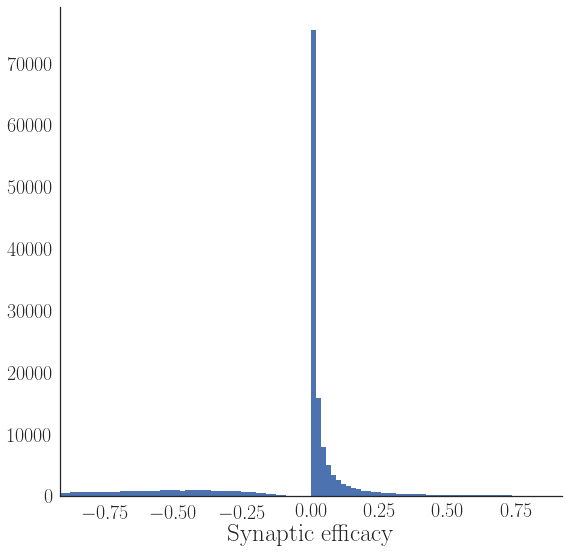

In [7]:
conn = dataa['connections']
plt.hist(conn.weight, bins=100);
plt.xlim([conn.weight.min(), conn.weight.max()])
plt.xlabel('Synaptic efficacy')
sns.despine()
savefig(plt.gcf(), 'connectivity-dist')

In [8]:
spiketrains = {s['sender']: {'pop': pop, 'times': s['times']}
               for pop in ['in', 'ex']
               for s in dataa['spiketrains'][pop]}

In [8]:
# B = 1
# # Find A and D
# affectors = conn.loc[(conn.target==B) & (conn.weight > 0)]
# m1 = affectors.weight.max()
# D = affectors[affectors.weight==m1].source
# D = int(D)
# m2 = conn.loc[(conn.source==D) & (conn.weight!=m1)].weight.max()
# A_ = conn.loc[(conn.source==D) & (conn.weight==m2)].target
# A_ = int(A_)
# print(A_, D)

121 650


In [128]:
# A, B, C = 11, 94, 978 print(A,B,C)

11 92 978


In [9]:
period = np.min(np.diff(dataa['epoch']['times']))
binsize = 1
bins = np.arange(0, period + binsize, binsize)
winsize = 4
latency = 3
N = 10000
names = ['A', 'B', 'C']

In [24]:
C = 979
B = conn.loc[conn.target==C].sort_values('weight', ascending=False).source.iloc[0]
A = conn.loc[(conn.source!=B) & (conn.target!=C) &
             (conn.source.isin(dataa['stim_nodes']['ex']))].source.iloc[0]

In [25]:
if A in set(conn.loc[conn.source==B].target): 
    weight = conn.loc[(conn.source==B) & (conn.target==A)].weight.sum()
    print('A is targeted by B, w = {:.4f}'.format(weight))
if A in set(conn.loc[conn.source==C].target): 
    print('A is targeted by C')
if B in set(conn.loc[conn.source==A].target): 
    print('B is targeted by A')
if B in set(conn.loc[conn.source==C].target): 
    print('B is targeted by C')
if C in set(conn.loc[conn.source==A].target): 
    print('C is targeted by A')
if C not in set(conn.loc[conn.source==B].target): 
    print('C is not targeted by B')
if C in set(conn.loc[conn.source==B].target): 
    weight = conn.loc[(conn.source==B) & (conn.target==C)].weight.sum()
    print('C is targeted by B, w = {:.4f}'.format(weight))

C is targeted by B, w = 0.7736


In [26]:
t_stop = dataa['params']['status']['time']

In [27]:
cc = corrcoef([spiketrains[A]['times'], 
          spiketrains[B]['times'], 
          spiketrains[C]['times']], t_stop=t_stop, binsize=4)
pd.DataFrame(cc, index=names, columns=names)

,A,B,C
A,1.000000,0.615696,0.132716
B,0.615696,1.000000,0.153529
C,0.132716,0.153529,1.000000


In [28]:
ivb = IV(spiketrains[B]['times'], 
         spiketrains[C]['times'],
         dataa['epoch']['times'],
         winsize, latency)

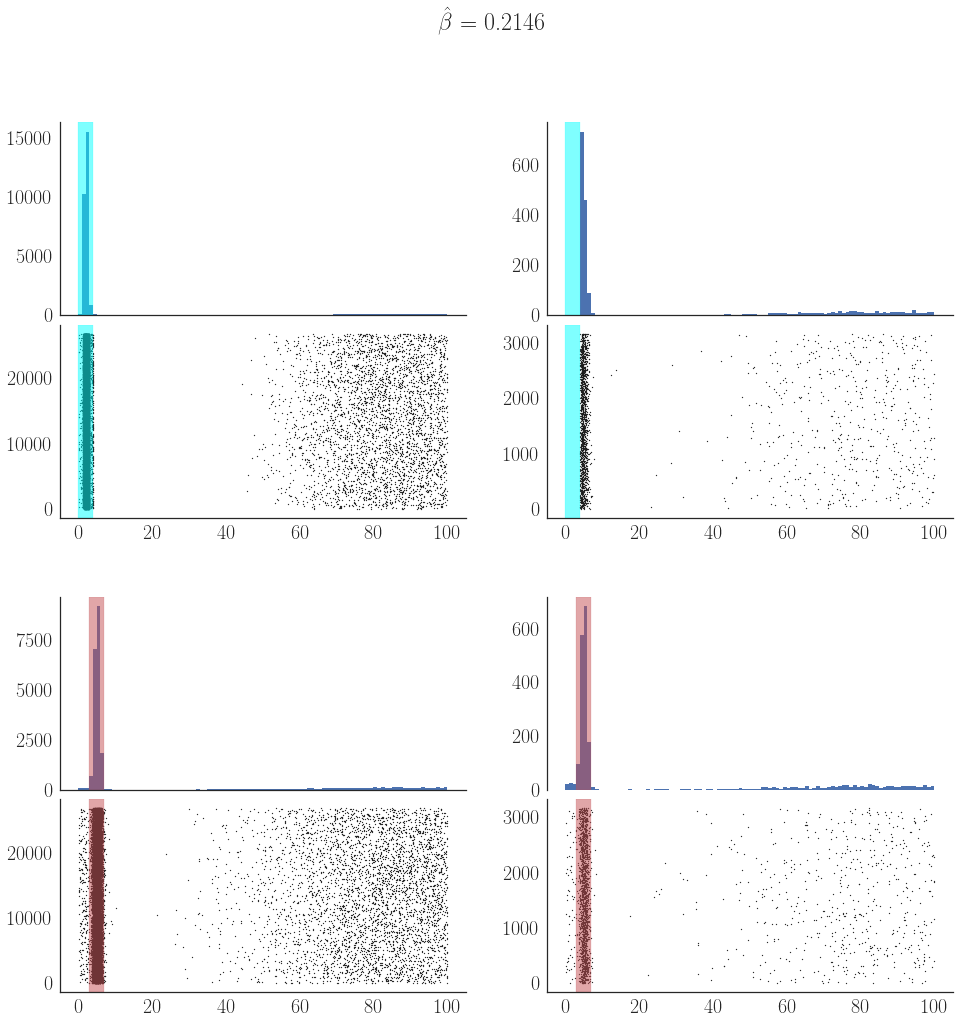

In [29]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(16,16))
gs = GridSpec(2, 2)
for i, idxs in enumerate([ivb.Stim, ivb.StimRef]):
    ivb.plot('source', idxs, gs=gs[0, i])
    ivb.plot('target', idxs, gs=gs[1, i])
plt.suptitle('$\\hat\\beta$ = {:.4f}'.format(ivb.wald));

In [49]:
ybs = ivb.lams[ivb.Stim, 1]
ybsr = ivb.lams[ivb.StimRef, 1]

ybns = ivb.lams[ivb.Stim, 3]
ybnsr = ivb.lams[ivb.StimRef, 3]

print(ybs.mean(), ybsr.mean(), ybs.sum(), ybsr.sum(), len(ybs), len(ybsr))
print(ybns.mean(), ybnsr.mean(), ybns.sum(), ybnsr.sum(), len(ybns), len(ybnsr))

In [30]:
iva = IV(spiketrains[A]['times'], 
         spiketrains[C]['times'],
         dataa['epoch']['times'][:N],
         winsize, latency)

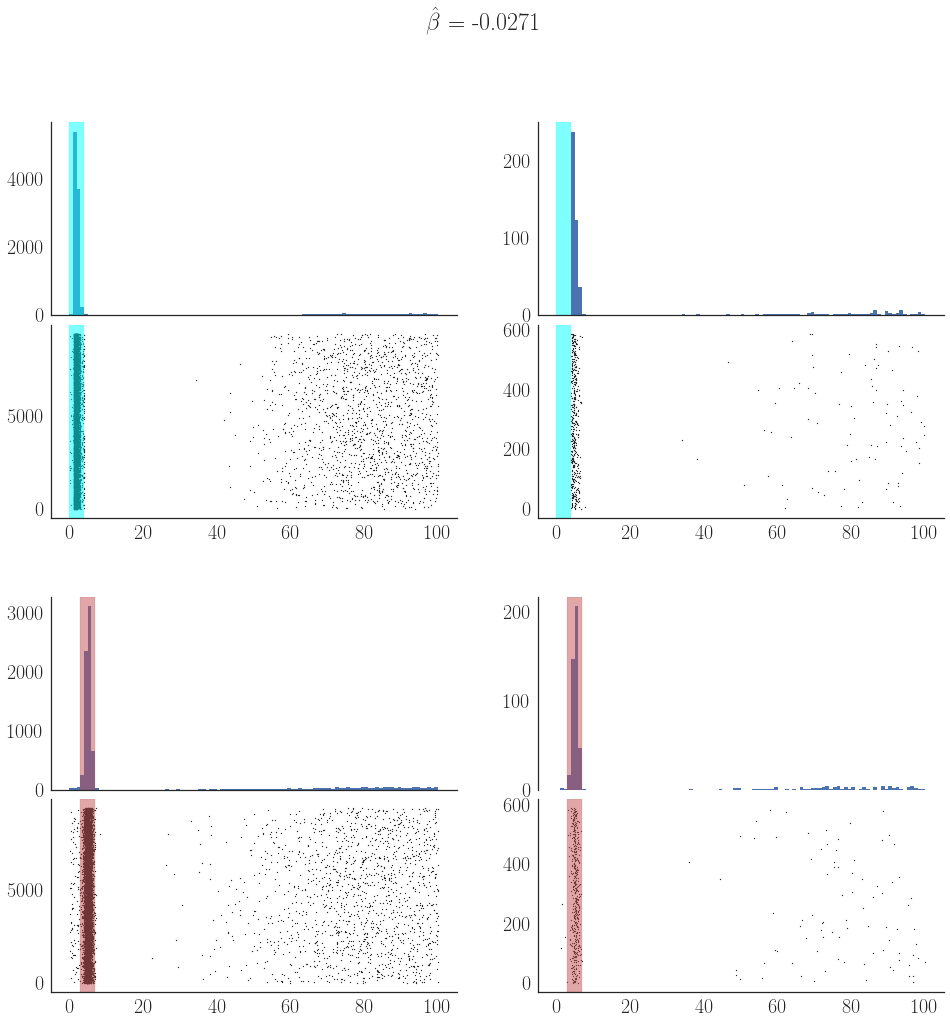

In [31]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(16,16))
gs = GridSpec(2, 2)
for i, idxs in enumerate([iva.Stim, iva.StimRef]):
    iva.plot('source', idxs, gs=gs[0, i])
    iva.plot('target', idxs, gs=gs[1, i])
plt.suptitle('$\\hat\\beta$ = {:.4f}'.format(iva.wald));

In [32]:
yas = iva.lams[iva.Stim, 1]
yasr = iva.lams[iva.StimRef, 1]

yans = iva.lams[iva.Stim, 3]
yansr = iva.lams[iva.StimRef, 3]

In [33]:
print(yas.mean(), yasr.mean(), yas.sum(), yasr.sum(), len(yas), len(yasr))
print(yans.mean(), yansr.mean(), yans.sum(), yansr.sum(), len(yans), len(yansr))

0.6797024442082891 0.7067796610169491 6396.0 417.0 9410 590
0.01487778958554729 0.013559322033898305 140.0 8.0 9410 590


In [34]:
def model(x):
    return 1/(1+np.exp(-x))

In [35]:
%%time
res = []
res_ns = []
regress = []
regress_ns = []
N_trials = [1000,2500,5000,7500,10000,12500,15000,17500,20000,25000,30000]
for N in N_trials:
    ws = [[], []]
    ws_ns = [[], []]
    regs = [[], []]
    regs_ns = [[], []]
    for i, AB in enumerate([A, B]):
        iv = IV(spiketrains[AB]['times'], spiketrains[C]['times'],
                 dataa['epoch']['times'][:N],
                 winsize, latency)
        ws[i].append(iv.wald)
        ws_ns[i].append(iv.wald_ns)
        logit = model(float(iv.logreg.coef_) + float(iv.logreg.intercept_))
        logit_ns = model(float(iv.logreg_ns.coef_) + float(iv.logreg_ns.intercept_))
        regs[i].append(logit)
        regs_ns[i].append(logit_ns)
    res.append(ws)
    res_ns.append(ws_ns)
    regress.append(regs)
    regress_ns.append(regs_ns)
res, res_ns, regress, regress_ns = np.array(res), np.array(res_ns), np.array(regress), np.array(regress_ns)

CPU times: user 7.64 s, sys: 8 ms, total: 7.65 s
Wall time: 7.65 s


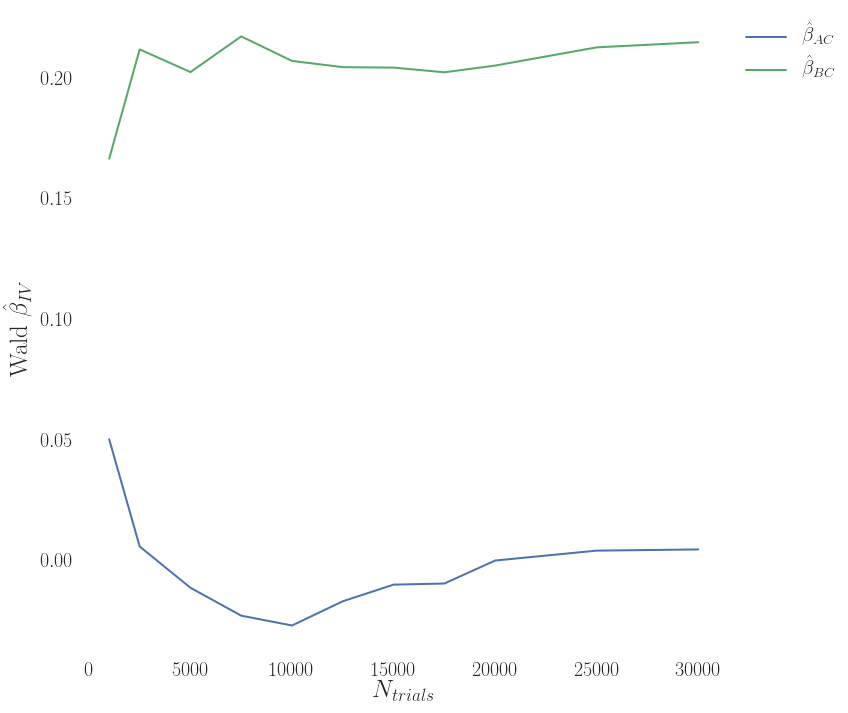

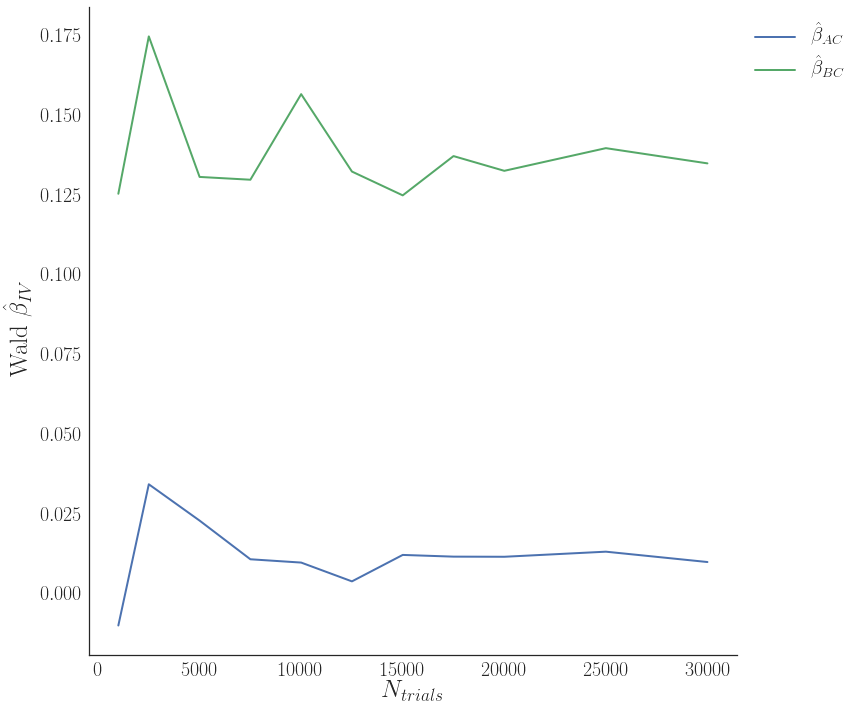

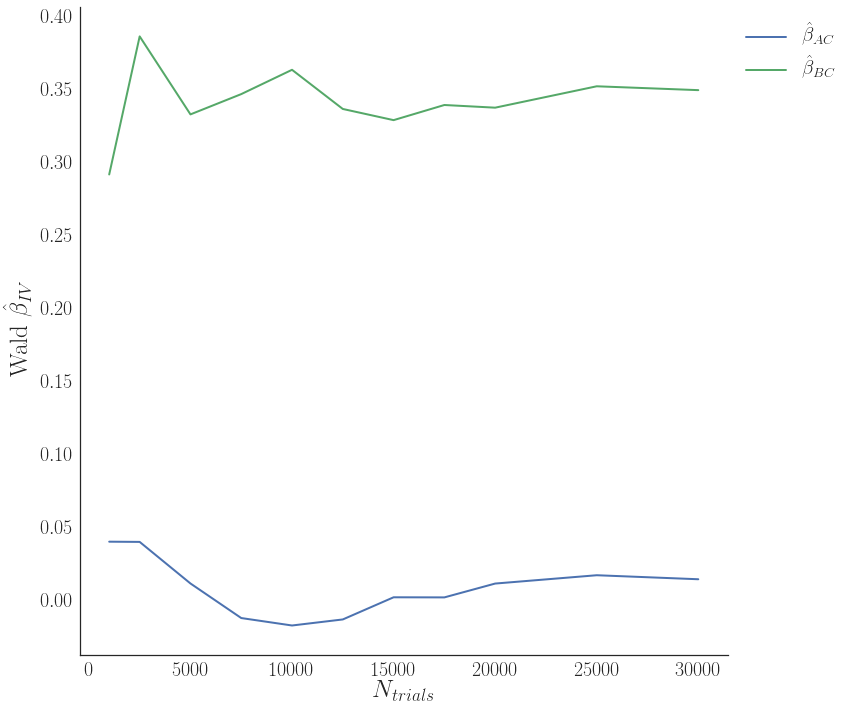

In [36]:
plt.figure()
plt.plot(N_trials, res[:,0], label='$\\hat\\beta_{AC}$')
plt.plot(N_trials, res[:,1], label='$\\hat\\beta_{BC}$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$N_{trials}$')
plt.ylabel('Wald $\\hat\\beta_{IV}$')
sns.despine(bottom=True, left=True)
fix_figure()
savefig(plt.gcf(), 'wald_network')

plt.figure()
plt.plot(N_trials, res_ns[:,0], label='$\\hat\\beta_{AC}$')
plt.plot(N_trials, res_ns[:,1], label='$\\hat\\beta_{BC}$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$N_{trials}$')
plt.ylabel('Wald $\\hat\\beta_{IV}$')
sns.despine()
fix_figure()
savefig(plt.gcf(), 'wald_network_ns')

plt.figure()
plt.plot(N_trials, res[:,0] + res_ns[:,0], label='$\\hat\\beta_{AC}$')
plt.plot(N_trials, res[:,1] + res_ns[:,1], label='$\\hat\\beta_{BC}$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$N_{trials}$')
plt.ylabel('Wald $\\hat\\beta_{IV}$')
sns.despine()
fix_figure()
savefig(plt.gcf(), 'wald_network_corrected')

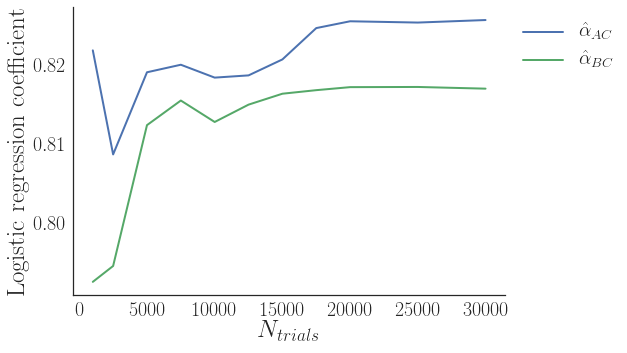

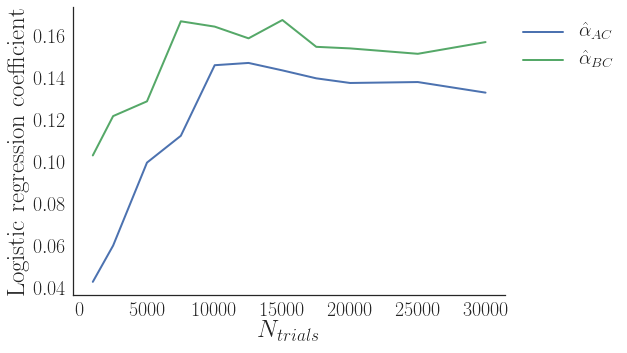

In [17]:
plt.figure()
plt.plot(N_trials, regress[:,0], label='$\\hat\\alpha_{AC}$')
plt.plot(N_trials, regress[:,1], label='$\\hat\\alpha_{BC}$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$N_{trials}$')
plt.ylabel('Logistic regression coefficient')
sns.despine()
fix_figure()

plt.figure()
plt.plot(N_trials, regress_ns[:,0], label='$\\hat\\alpha_{AC}$')
plt.plot(N_trials, regress_ns[:,1], label='$\\hat\\alpha_{BC}$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$N_{trials}$')
plt.ylabel('Logistic regression coefficient')
sns.despine()
fix_figure()

In [37]:
t_stop = dataa['params']['status']['time']
spiketrains_ABC = [spiketrains[idx]['times'] for idx in [A, B, C]]
names = ['A', 'B', 'C']
colors = sns.color_palette()

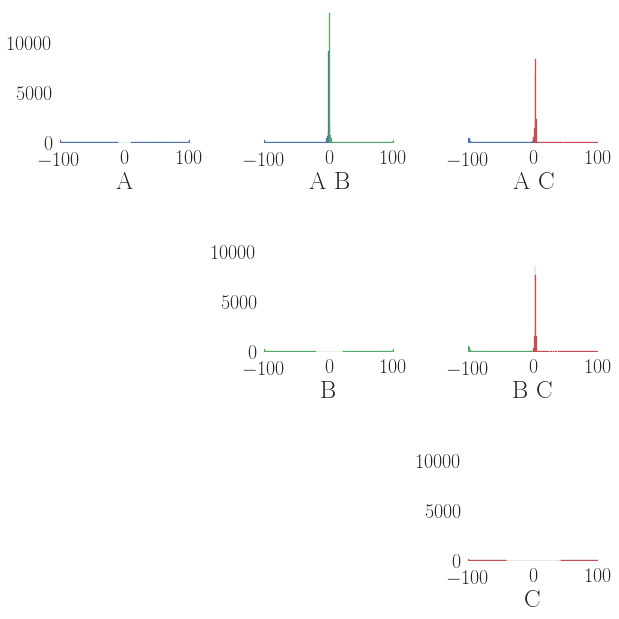

In [38]:
plot_xcorr(spiketrains_ABC, colors=colors, time_limit=100, binsize=1,
           xticksvisible=True, yticksvisible=False, density=False,
           names=names);
sns.despine(bottom=True, left=True)
fig = plt.gcf()
savefig(fig, 'xcorr_network')

In [45]:
from exana.statistics.tools import ccg_significance

time_limit = 30
binsize = 1
ylim = [0, 10000]


8563
8402


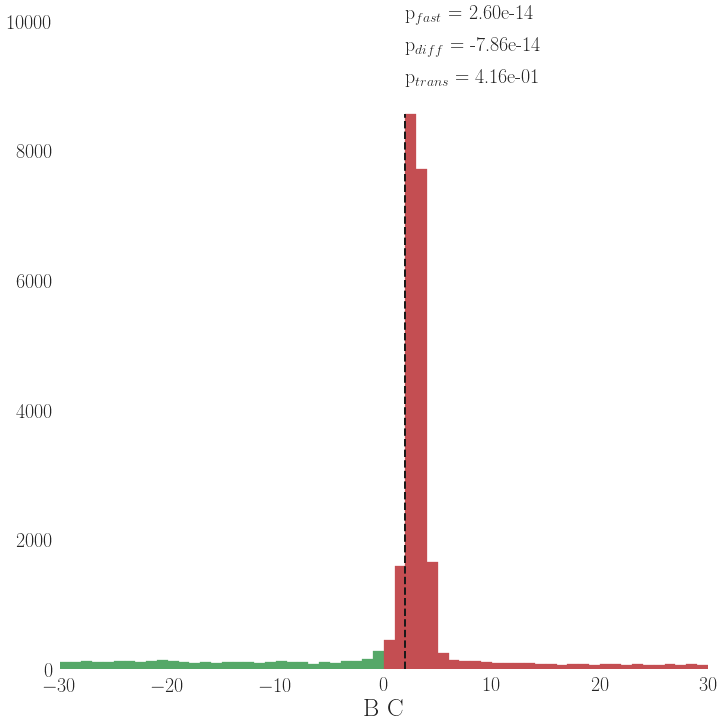

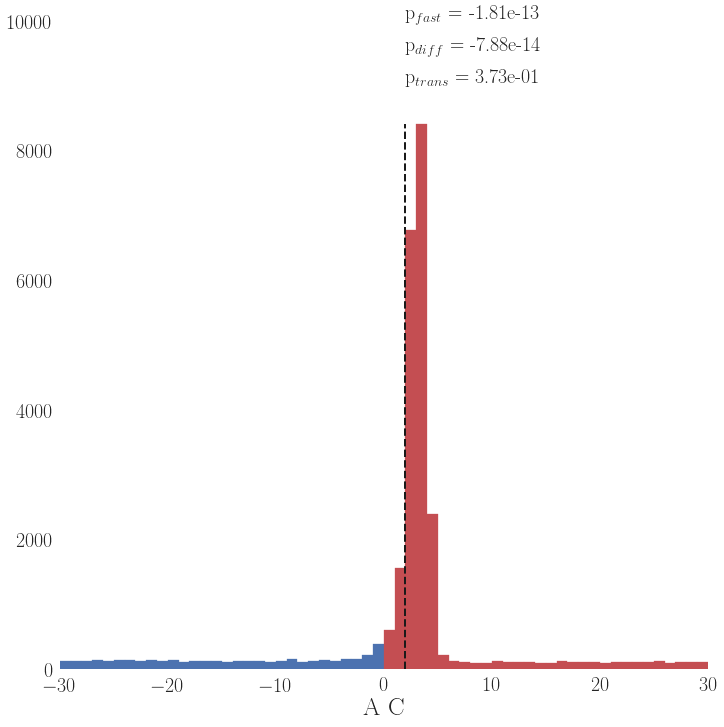

In [46]:
for idx, sl in enumerate([slice(1,3), slice(0,3,2)]):
    pcausal, pfast, bins, cch, cch_s = ccg_significance(*spiketrains_ABC[sl], binsize, time_limit, 
                                            hollow_fraction=.6, width=10)
    
    _, _ = plot_xcorr(spiketrains_ABC[sl], colors=colors[sl], time_limit=time_limit, 
                            binsize=binsize, acorr=False, ylim=ylim, density=False,
                            names=names[sl]);
    ax = plt.gca()
    mask = (bins >= latency) & (bins <= latency + winsize)
    m = np.max(cch[mask])
    print(m)
    pmin = pcausal[cch == m]
    trans_prob = sum(cch[mask] - cch_s[mask]) / len(spiketrains_ABC[sl][0])
    plt.plot([bins[pcausal==pmin][0], bins[pcausal==pmin][0]], 
             [0, m], ls='--', c='k')
    plt.annotate('p$_{{fast}}$ = {:.2e}'.format(pfast[cch == m][0]), 
                 [bins[pcausal == pmin][0], ylim[1]])
    plt.annotate('p$_{{diff}}$ = {:.2e}'.format(pcausal[cch == m][0]), 
                 [bins[pcausal == pmin][0], ylim[1] - ylim[1]*.05])
    plt.annotate('p$_{{trans}}$ = {:.2e}'.format(trans_prob), 
                 [bins[pcausal == pmin][0], ylim[1] - ylim[1]*.1])
    ax.set_aspect(time_limit * 2 / ylim[1])
    ax.set_position([0, 0, 1, 1])
    sns.despine(bottom=True, left=True)

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/matplotlib/patches.py:1051: RuntimeWarning: divide by zero encountered in true_divide
  v2 = arc.vertices[::-1] * float(self.r - self.width) / self.r
/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/matplotlib/patches.py:1051: RuntimeWarning: invalid value encountered in true_divide
  v2 = arc.vertices[::-1] * float(self.r - self.width) / self.r
/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/matplotlib/patches.py:1061: RuntimeWarning: invalid value encountered in multiply
  v *= self.r


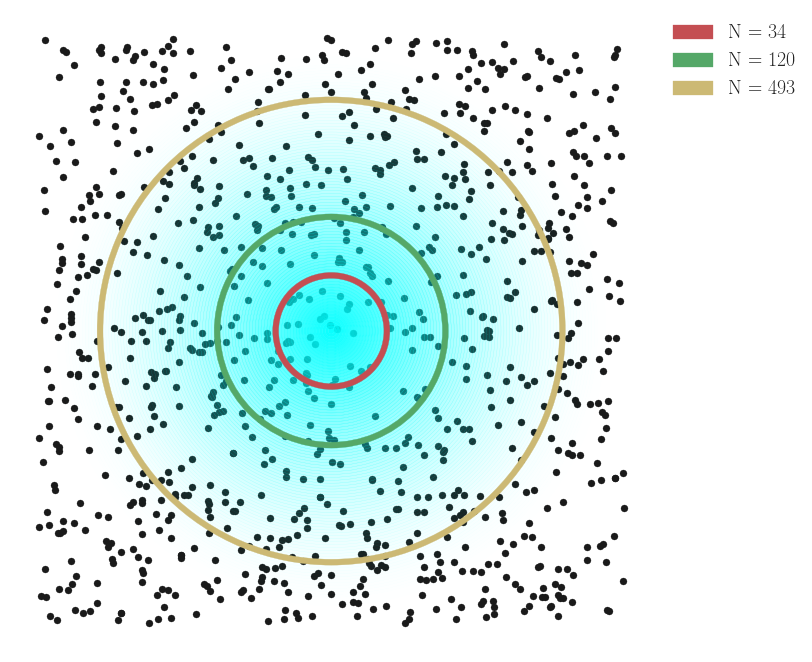

In [238]:
from matplotlib.patches import Circle, Wedge
from matplotlib.collections import PatchCollection
fig, ax = plt.subplots(figsize=(9,9))
size = 2.
x = np.random.uniform(-size*.5,size*.5,1000)
y = np.random.uniform(-size*.5,size*.5,1000)
ax.scatter(x,y,color='k')

width = .01
radiuses = np.arange(0,1., width)

for r, a in zip(radiuses, radiuses[::-1]):
    ax.add_patch(Wedge((0, 0), r, 0, 360, width=width, color='cyan', alpha=a**2))
for r, c in zip([.2,.4, .8], ['r', 'g', 'y']):
    count = 0
    for xx, yy in zip(x,y):
        if np.sqrt(xx**2 + yy**2) < r:
            count += 1
    ax.add_patch(Wedge((0, 0), r, 0, 360, width=0.02, color=c, label='N = {}'.format(count)))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
sns.despine(bottom=True, left=True)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False);
fix_figure()
savefig(fig, 'network_stim')

In [260]:
amp = np.random.pareto(2,1000)
amp = amp/max(amp) * 10

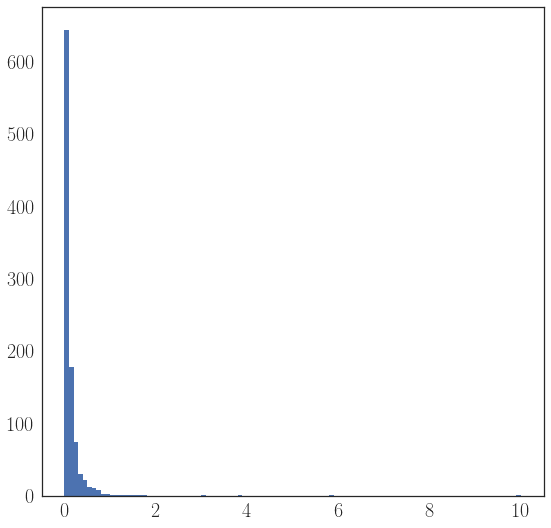

In [261]:
plt.hist(amp, bins=100);

In [422]:
def rho(**kw):
    p = {
        'r': 100e-3, # 100 um radius of fiber
        'n': 1.36, # refraction index of gray matter
        'NA': 0.37, # Numerical Aperture of fiber
    }
    if kw:
        p.update(kw)
    return p['r'] * np.sqrt((p['n'] / p['NA'])**2 - 1)


def intensity(z, **kw):
    p = {
        'S': 10.3, # mm^-1 scattering index for rat, mouse = 11.2
    }
    if kw:
        p.update(kw)
    r = rho(**kw)
    return r**2 / ((p['S'] * z + 1) * (z + r)**2)

[0.00604161]


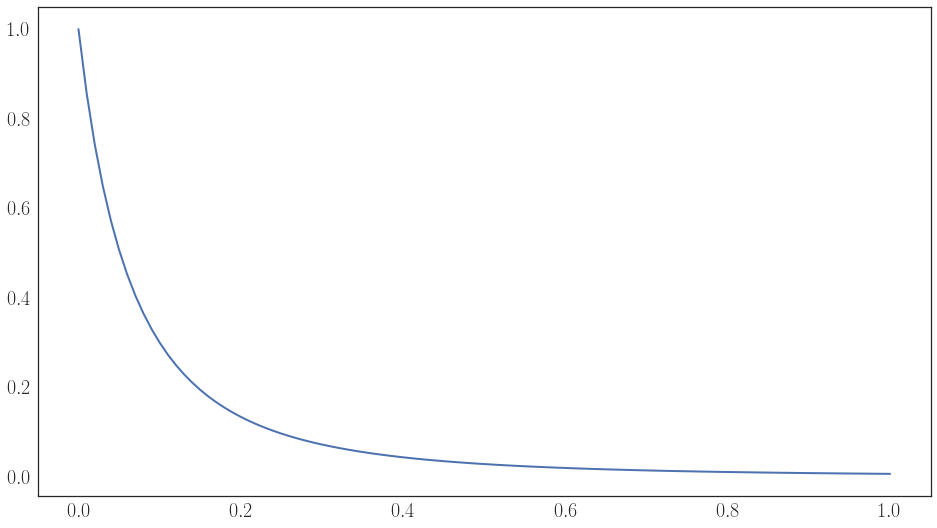

In [421]:
set_style('notebook')
plt.figure(figsize=(16,9))
z = np.arange(0,1.01,.01)
I = intensity(z)
print(I[z==1.])
plt.plot(z,I);

20640.295932539706


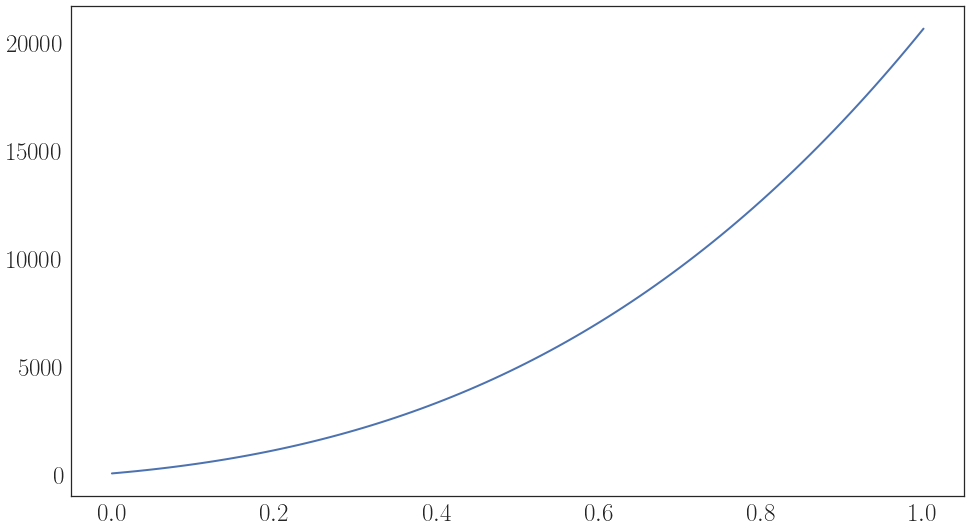

In [485]:
def n_neurons(l, ret='sum', **kw):
    p = {
        'r': 100e-3, # mm, 100 um radius of fiber
        'n': 1.36, # refraction index of gray matter
        'NA': 0.37, # Numerical Aperture of fiber
        'density': 10e4, # N/mm³
    }
    if kw:
        p.update(kw)
    theta = np.arcsin(p['NA'] / p['n'])
    lcorr = p['r'] / np.tan(theta)
    rad = (l + lcorr) * np.tan(theta)
    A = np.pi * rad**2
    dl = l[1] - l[0]
#     V = 1 / 3 * np.pi * l[-1] * (p['r']**2 + p['r'] * rad[-1] + rad[-1]**2)
#     print(V, V*p['density'])
    dV = A * dl
#     print(np.trapz(dV * p['density']/dl, dx=dl))
#     print(sum(dV * p['density']))
    N = dV * p['density']
    if ret == 'sum':
        return np.array([np.sum(N[:i+1]) for i in range(len(N))])
    elif ret == 'count':
        return N
    else:
        raise NotImplementedError

N = n_neurons(r)
print(max(N))
plt.plot(r, N)

2242


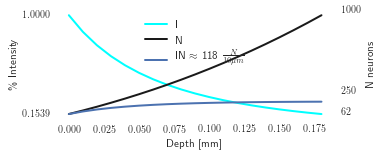

In [501]:
set_style('article')
fig, ax1 = plt.subplots()
r = np.arange(0,1.01,.01)
neurons = n_neurons(r)
light = intensity(r)
mask = neurons <= 1000
neurons, light, r = [a[mask] for a in [neurons, light, r]]
print(len(neurons)*118)
prob = light * neurons

l, = ax1.plot(r, light, c='cyan', label='I')

ax2 = ax1.twinx()
n, = ax2.plot(r, neurons, 'k', label='N')
p, = ax2.plot(r, prob, label='IN $\\approx$ {:.0f} $\\frac{{N}}{{10\\mu m}}$'.format(prob.mean()))
despine(right=True, top=True, left=True, bottom=True, xticks=True, ax=[ax1,ax2])
ax1.set_yticks([light.min(), 1])
ax2.set_yticks([62, 250, 1000])
ax2.set_ylabel('N neurons')
ax1.set_ylabel('\% Intensity')
ax1.set_xlabel('Depth [mm]')
# ax1.set_xticks([])
plt.legend(handles=[l,n,p], loc=9)
# fix_figure(padLegend=.5, padHeight=.1)
savefig(fig, 'opto-powerlaw', bbox_inches='tight')

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/matplotlib/patches.py:1051: RuntimeWarning: divide by zero encountered in true_divide
  v2 = arc.vertices[::-1] * float(self.r - self.width) / self.r
/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/matplotlib/patches.py:1051: RuntimeWarning: invalid value encountered in true_divide
  v2 = arc.vertices[::-1] * float(self.r - self.width) / self.r
/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/matplotlib/patches.py:1061: RuntimeWarning: invalid value encountered in multiply
  v *= self.r


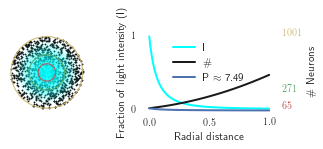

In [468]:
from matplotlib.patches import Circle, Wedge
from matplotlib.collections import PatchCollection
set_style('article')

fig, (ax, ax1) = plt.subplots(1, 2)

size = 2.
x, y, cnt = [], [], 0
while cnt <= 1000:
    xx = np.random.uniform(-size*.5,size*.5,1)
    yy = np.random.uniform(-size*.5,size*.5,1)
    if np.sqrt(xx**2 + yy**2) < 1:
        x.append(xx)
        y.append(yy)
        cnt += 1
            
ax.scatter(x, y, color='k', s=2)
c_colors = ['r', 'g', 'y']
width = .01
radiuses = np.arange(0,1., width)
counts = []
for r, a in zip(radiuses, radiuses[::-1]):
    ax.add_patch(Wedge((0, 0), r, 0, 360, width=width, color='cyan', alpha=a**2))
for r, c in zip([.25,.5, 1.], c_colors):
    count = 0
    for xx, yy in zip(x,y):
        if np.sqrt(xx**2 + yy**2) < r:
            count += 1
    counts.append(count)
    ax.add_patch(Wedge((0, 0), r, 0, 360, width=0.02, color=c))
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False);
ax.set_aspect(1)


r = np.arange(0,1.01,.01)
light = intensity(r)
neurons = n_neurons(r)
prob = light * neurons

l, = ax1.plot(r, light, c='cyan', label='I')

ax2 = ax1.twinx()
n, = ax2.plot(r, neurons, 'k', label='\#')

p, = ax2.plot(r, prob, label='P $\\approx$ {:.2f}'.format(prob.mean()))

despine(right=True, top=True, left=True, bottom=True, xticks=True, ax=[ax, ax1,ax2])
ax1.set_yticks([0, 1])
ax2.set_yticks(counts)
ax2.set_ylabel('\# Neurons')
ax1.set_ylabel('Fraction of light intensity (I)')
ax1.set_xlabel('Radial distance')
# ax1.set_xticks([1,2,3,4])
plt.legend(handles=[l,n,p], loc=9)
# fix_figure(padLegend=.5, padHeight=.1)
plt.tight_layout()
for c, t in zip(c_colors, ax2.yaxis.get_ticklabels()):
    t.set_color(c)
savefig(fig, 'opto-powerlaw-comb')